# Two Market Makers - via Pontryagin

This notebook corresponds to section 4 (**Agent based models**) of "Market Based Mechanisms for Incentivising Exchange Liquidity Provision" available [here](https://vega.xyz/papers/liquidity.pdf). It models two market makers and solves the resulting game by an iterative scheme based on the Pontryagin optimality principle.

In [1]:
import math, sys 
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
T = 0.4;
sigma0 = 3
sigma1 = 0.5
lambd = 0.1
r = 0.0
rRisk0 = 0.3
rRisk1 = 0.1

delta_a = 1e-4
fee_scaling = 0.1


# This is key; how does instantenaous trading volume react 
# to market making stake
# and to fees. You could specify different beleifs for the two different agents.

def fee_volume_response(f):
    f = np.maximum(f, np.zeros(np.size(f)))
    f = np.minimum(f, np.ones(np.size(f)))
    return 1.0/(f+0.01) - f

def stake_volume_response(S):
    return 1.0 / (1+np.exp(-0.05*S+2)) - 1.0 / (1+np.exp(2))

Max 0.091563


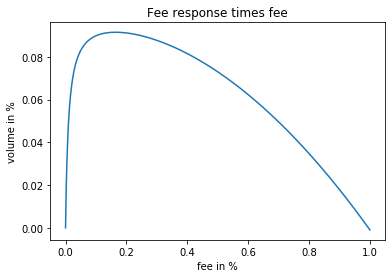

In [3]:
# Check that the shape below is concave (i.e. there is a single maximum) we need 
# this if we want the optimization procedure to converge
x_span = np.linspace(0,1, 1000) 
y = fee_scaling * fee_volume_response(x_span) * x_span
print('Max %f' % max(y))
max_idx=np.argmax(y)
plt.xlabel('fee in %')
plt.ylabel('volume in %')
plt.title('Fee response times fee')
plt.plot(x_span,y)

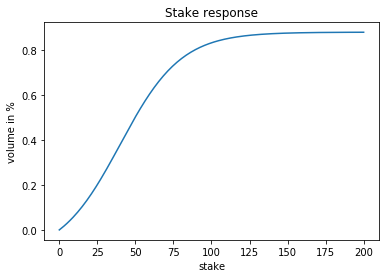

In [4]:
# Check that the shape below is concave (i.e. there is a single maximum) we need 
# this if we want the optimization procedure to converge.
# Of course you may be lucky and things will work even in the case when it's not exactly convex... 
x_span = np.linspace(0,200, 200) 
y = stake_volume_response(x_span)
plt.xlabel('stake')
plt.ylabel('volume in %')
plt.title('Stake response')
plt.plot(x_span,y)

In [5]:
# As things are set-up at moment the agents only differ in their belief about
# the maximum trading volume they'd expect to see
def trading_volume0(f,S):
    N_max = 10000
    return  N_max * fee_volume_response(f) * stake_volume_response(S)

def trading_volume1(f,S):
    N_max = 50000
    return  N_max * fee_volume_response(f) * stake_volume_response(S)

def running_gain0(t,f,S0,S1,a0):
    frac = S0/(S0+S1)
    stake = S0+S1
    return np.exp(-r*t) * (frac * fee_scaling * f * trading_volume0(f,stake) - max(lambd * sigma0 * S0,0)) - max(np.exp(rRisk0*t)*S0, 0) \
              - delta_a * a0*a0

def running_gain1(t,f,S0,S1,a1):
    frac = S1/(S0+S1)
    stake = S0+S1
    return np.exp(-r*t) * (frac * fee_scaling * f * trading_volume1(f,stake) - max(lambd * sigma1 * S1,0)) - max(np.exp(rRisk1*t)*S1, 0) \
              - delta_a * a1*a1

def running_gain_x_0(t,x,S_1, a0):
    f = x[0]
    S_0 = x[1]
    return running_gain0(t,f,S_0,S_1, a0)

def running_gain_x_1(t,x,S_0, a1):
    f = x[0]
    S_1 = x[1]
    return running_gain1(t,f,S_0,S_1, a1)

In [6]:
# Below we define the gradients (using finite difference)
# of the running gain specified above - this is just a technicality
# used in the subsequent optimization.

def grad_x_of_running_gain_0(t,x,S1,a):
    delta = 1e-8
    grad = np.zeros(2)

    #print(x)
    x_plus = x + np.array([delta, 0])
    x_minus = x - np.array([delta, 0])
    rg_plus = running_gain_x_0(t,x_plus,S1,a)
    rg_minus = running_gain_x_0(t,x_minus,S1,a)
    #print(x_plus)
    grad[0] = (rg_plus - rg_minus)/(2*delta)
    
    x_plus = x + np.array([0, delta])
    x_minus = x - np.array([0, delta])
    rg_plus = running_gain_x_0(t,x_plus,S1,a)
    rg_minus = running_gain_x_0(t,x_minus,S1,a)
    grad[1] = (rg_plus - rg_minus)/(2*delta)
                            
    return grad

def grad_x_of_running_gain_1(t,x,S0,a):
    delta = 1e-8
    grad = np.zeros(2)

    x_plus = x + np.array([delta, 0])
    x_minus = x - np.array([delta, 0])
    rg_plus = running_gain_x_1(t,x_plus,S0,a)
    rg_minus = running_gain_x_1(t,x_minus,S0,a)
    grad[0] = (rg_plus - rg_minus)/(2*delta)
    
    x_plus = x + np.array([0, delta])
    x_minus = x - np.array([0, delta])
    rg_plus = running_gain_x_1(t,x_plus,S0,a)
    rg_minus = running_gain_x_1(t,x_minus,S0,a)
    grad[1] = (rg_plus - rg_minus)/(2*delta)
                            
    return grad

In [7]:
# Initialization 
L_S = 150;
L_f = 1;

N_T = 200; delta_t = T / (N_T-1);
N_S = 45; 
N_f = 45; 

t_span = np.linspace(0, T, N_T)
f_span = np.linspace(0, L_f, N_f)
S_span = np.linspace(0, L_S, N_S)

def grid_idx_from(S,S_span):
    min_S = S_span[0]
    N_S = np.size(S_span)
    max_S = S_span[N_S-1]
    delta_S = (max_S-min_S)/(N_S-1)
    return max(min(int(round(S/delta_S)), N_S-1),0)

In [8]:
F_vals = np.zeros([np.size(f_span), np.size(S_span)])
f_times_V_vals = np.zeros([np.size(f_span), np.size(S_span)])
grad_F_vals = np.zeros([np.size(f_span), np.size(S_span), 2])
for f_idx in range(0, np.size(f_span)):
    for S_idx in range(0, np.size(S_span)):
        f = f_span[f_idx]
        S = S_span[S_idx]
        F_vals[f_idx,S_idx] = running_gain0(T, f, S, 10, 0)
        f_times_V_vals[f_idx,S_idx] = f*trading_volume0(f,S)
        grad_F_vals[f_idx,S_idx,:] = grad_x_of_running_gain_0(T, np.array([f, S]), 10, 0)
        
max_idx = np.unravel_index(np.argmax(F_vals, axis=None),F_vals.shape)
print(f_span[max_idx[0]])
print(S_span[max_idx[1]])

0.1590909090909091
105.68181818181819


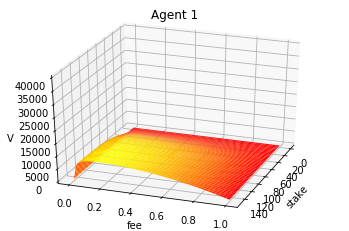

In [9]:
plotGridX, plotGridY = np.meshgrid(S_span, f_span)
fig = plt.figure()
#ax1 = fig.add_subplot(111,projection='3d')
ax1 = fig.gca(projection='3d')
surf = ax1.plot_surface(plotGridX, plotGridY, f_times_V_vals[:,:], cmap=cm.autumn, antialiased=True)
ax1.set_xlabel('stake')
ax1.set_ylabel('fee')
ax1.set_zlabel('V')
ax1.set_zlim(0, 40000)
ax1.view_init(30, 20)
ax1.set_title('Agent 1')
plt.savefig('response1.pdf')


In [10]:
gamma_f = -0.02
gamma_S = 5
m = 1

def drift_0(a0,a1):
    b = np.zeros(2)
    b[0] = gamma_f*(a0+a1)
    b[1] = gamma_S*a0
    return b

def drift_1(a0,a1):
    b = np.zeros(2)
    b[0] = gamma_f*(a0+a1)
    b[1] = gamma_S*a1
    return b  

def grad_a0_H0(y,a0,a1):
    val = gamma_f*y[0] + gamma_S*y[1] - 2*delta_a*a0 
    return val

def grad_a1_H1(y,a0,a1):
    val = gamma_f*y[0] + gamma_S*y[1] - 2*delta_a*a1
    return val

In [11]:
# Fix initial fee & and stake of two players
fee_init = 0.5 # has to be between 0 and 1
player0_stake = 250
player1_stake = 10

# Learning params:
# higher value means faster convergence but less stability i.e.: 
# if you see stupid output (explosion, negative fees etc.) set this lower. 
rho = 0.05       

# learning takes a long time and if it says "failed at the end it might just means that it's still updating a bit."
max_iter = 6000  

#stopping criteria: once the updates are smaller than this in l-infinity then stop 
max_error = 0.1 

# fees are the 0th component, stake is the 1st component
# first player, index 0
actions0 = np.zeros([1,N_T+1])

x_vals0 = np.zeros([2,N_T+1])
x_vals0[:,0] = np.array([fee_init, player0_stake])
y_vals0 = np.zeros([2,N_T+1])
# second player, index 1
actions1 = np.zeros([1,N_T+1])

x_vals1 = np.zeros([2,N_T+1])
x_vals1[:,0] = np.array([fee_init, player1_stake])
y_vals1 = np.zeros([2,N_T+1])



def run_iterative_system(max_iter,max_error):
    actions_old0 = np.zeros([1,N_T+1])
    actions_old1 = np.zeros([1,N_T+1])
    diff = 0; failed_to_converge=True
    
    for iter_idx in range(0,max_iter):
        # Run x0, x1 forwards
        for i in range(0,N_T):
            x_vals0[:,i+1] = x_vals0[:,i] + drift_0(actions0[0,i], actions1[0,i]) * delta_t
            # second guy only updates the stake
            # but the fee evolution is copied from first
            x_vals1[0,i+1] = x_vals0[0,i+1]
            x_vals1[1,i+1] = x_vals1[1,i] + drift_1(actions0[0,i], actions1[0,i])[1] * delta_t

    
        # Run y0, y1 backwards
        y_vals0[:,N_T] = np.zeros(2)
        y_vals1[:,N_T] = np.zeros(2)
        for i in reversed(range(0,N_T)):
            S0 = x_vals0[1,i]
            S1 = x_vals1[1,i]
            grad_x_F_0 = grad_x_of_running_gain_0(t_span[i], x_vals0[:,i], S1, actions0[0,i])
            grad_x_F_1 = grad_x_of_running_gain_1(t_span[i], x_vals1[:,i], S0, actions1[0,i])
            y_vals0[:,i] = y_vals0[:,i+1] + grad_x_F_0 * delta_t 
            y_vals1[:,i] = y_vals1[:,i+1] + grad_x_F_1 * delta_t         
        
        for i in range(0,N_T):
            # Do one gradient ascent step (we are maximizing) 
            actions0[0,i] = actions0[0,i] + rho*grad_a0_H0(y_vals0[:,i],actions0[0,i],actions1[0,i])
            actions1[0,i] = actions1[0,i] + rho*grad_a1_H1(y_vals1[:,i],actions0[0,i],actions1[0,i])
        
        diff0 = np.max(np.abs(actions0 - actions_old0))
        diff1 = np.max(np.abs(actions1 - actions_old1))
        if (diff0 < max_error) and (diff1 < max_error) :
            print('Converged; iteration %d, diff0 is %f, diff1 is %f' % (iter_idx, diff0, diff1))
            failed_to_converge = False
            break 
        actions_old0 = np.copy(actions0)
        actions_old1 = np.copy(actions1)    

    if failed_to_converge:
        print('Failed after %d iteration, diff0 is %f, diff1 is %f' % (max_iter, diff0,diff1))
        
        
%timeit -n1 -r1 run_iterative_system(max_iter, max_error)

Converged; iteration 3595, diff0 is 0.021513, diff1 is 0.099986
3min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


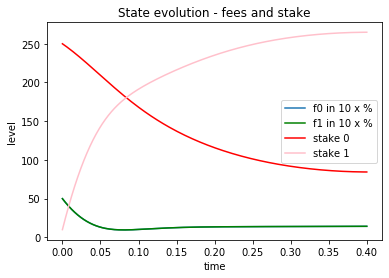

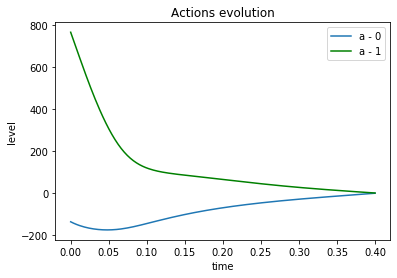

In [12]:
plt.plot(t_span, 1000 * fee_scaling * x_vals0[0,0:N_T].T,label='f0 in 10 x %')
plt.plot(t_span, 1000 * fee_scaling * x_vals1[0,0:N_T].T,color='green',label='f1 in 10 x %')
plt.xlabel('time')
plt.plot(t_span, x_vals0[1,0:N_T].T,color='red',label='stake 0')
plt.plot(t_span, x_vals1[1,0:N_T].T,color='pink',label='stake 1')
plt.title('State evolution - fees and stake')
plt.xlabel('time')
plt.ylabel('level')
plt.legend()
plt.savefig('state.pdf')

fig = plt.figure()
plt.plot(t_span, actions0[0,0:N_T].T,label='a - 0')
plt.plot(t_span, actions1[0,0:N_T].T, color='green',label='a - 1')
plt.title('Actions evolution')
plt.xlabel('time')
plt.ylabel('actions fees')
plt.xlabel('time')
plt.ylabel('level')
plt.legend()
plt.savefig('actions.pdf')

In [13]:
print('Minimum fee %.2f%%. Final fee %.2f%%.' % (fee_scaling * 100*min(x_vals1[0,0:N_T]),fee_scaling * 100*x_vals1[0,N_T-1]))
print('Minimum stake %.0f. Maximum stake %.0f. Final stake %.0f.' % (min(x_vals0[1,0:N_T]+x_vals1[1,0:N_T]),max(x_vals0[1,0:N_T]+x_vals1[1,0:N_T]),x_vals0[1,N_T-1]+x_vals1[1,N_T-1]))

Minimum fee 0.96%. Final fee 1.43%.
Minimum stake 260. Maximum stake 361. Final stake 349.


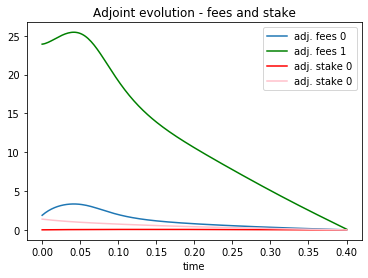

In [14]:
# Adjoint process plot: this is a 'dummy' process used in the optimization
# and you can ignore it if all goes well

fig = plt.figure()
plt.plot(t_span, 0.1*y_vals0[0,0:N_T].T, label='adj. fees 0')
plt.plot(t_span, 0.1*y_vals1[0,0:N_T].T, color='green', label='adj. fees 1')
plt.xlabel('time')
plt.plot(t_span, y_vals0[1,0:N_T].T, color = 'red', label='adj. stake 0')
plt.plot(t_span, y_vals1[1,0:N_T].T, color = 'pink', label='adj. stake 0')
plt.title('Adjoint evolution - fees and stake')
plt.xlabel('time')
plt.legend()

